# Interactive Weak Supervision 

This notebook contains code to perform the same experiments on text data as in:

Boecking, B., Neiswanger, W., Xing, E.P., & Dubrawski, A. (2021). [Interactive Weak Supervision: Learning Useful Heuristics for Data Labeling](https://arxiv.org/abs/2012.06046). *International Conference on Learning Representations (ICLR).*


# We'll take care of all imports first

In [1]:
import os
import pickle
import numpy as np
import torch
import pandas as pd
from utils import AVAILABLEDATASETS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from snorkel.labeling.model import LabelModel
from torchmodels import TorchMLP

from utils import generate_ngram_LFs, get_final_set, train_end_classifier
from iws import InteractiveWeakSupervision

# Available datasets
If you have not yet downloaded the text datasets used in our paper, first run:
```bash
cd datasets
wget https://ndownloader.figshare.com/files/25732838?private_link=860788136944ad107def -O iws_datasets.tar.gz
tar -xzvf iws_datasets.tar.gz
rm iws_datasets.tar.gz
```


In [2]:
print('\n'.join([x for x in os.listdir('datasets') if x.endswith('.csv')]))

IMDB.csv
professor_physician.csv
painter_architect.csv
professor_teacher.csv
journalist_photographer.csv
Amazon.csv


# In this version of the notebook, we'll demonstrate IWS with the IMDB sentiment analysis dataset

In [3]:
dname = 'IMDB'

# Load data

In [4]:
df = pd.read_csv('datasets/%s.csv'%dname)
corpus = df[df.fold==0].text.tolist()
corpus_test = df[df.fold==1].text.tolist()

Ytrain = df[df.fold==0].label.to_numpy()
Ytest = df[df.fold==1].label.to_numpy()

# Create features for the end classifier we will train
We create simple bag of words features for each document to avoid influencing final results by using pretrained embeddings. 

In [5]:
# Build 1-gram vocabulary. 
mindf = 10.0/len(corpus)
vectorizer = CountVectorizer(strip_accents='ascii',stop_words='english',ngram_range=(1, 1), analyzer='word', max_df=0.90, min_df=mindf, max_features=None, vocabulary=None, binary=False)
Xunigram = vectorizer.fit_transform(corpus)
Xunigramtest = vectorizer.transform(corpus_test)
n,m = Xunigram.shape
if m < 300:
    Xsvd = np.asarray(Xunigram.todense()).astype(np.float32)
    Xtestsvd = np.asarray(Xunigramtest.todense()).astype(np.float32)
else:        
    svd = TruncatedSVD(n_components=300, n_iter=20, random_state=42)
    Xsvd = svd.fit_transform(Xunigram).astype(np.float32)
    Xtestsvd = svd.transform(Xunigramtest).astype(np.float32)


# Generate large number of candidate LFs on text
## generate unigram LFs

We generate a large number of heuristics as well as a description to show to experts

In [6]:
LFs,lf_descriptions = generate_ngram_LFs(corpus,'unigram')

## Create LF features
IWS will use these features to predict probability that an LF is better than random

In [7]:
svd = TruncatedSVD(n_components=150, n_iter=20, random_state=42)
LFfeatures = svd.fit_transform(LFs.T).astype(np.float32)

# Choose some LFs to initialize the algorithm

## **!!These need to be changed if you are not using the IMDB dataset!!**

In [8]:
# Let's hand pick some words to start with
positive_sentiment_words = ['adorable','witty']
negative_sentimen_words = ['stereotypical','hated']
start_idxs = []
halfway= int(len(lf_descriptions)/2)# we generated positive LFs first, then negative
# iterate over positive LFs
for i,desc in enumerate(lf_descriptions[:halfway]):
    for word in positive_sentiment_words:
        if word in desc:
            start_idxs.append(i)
            if len(start_idxs)==2:
                break
    if len(start_idxs)==2:
        break

# iterate over negative LFs
for i,desc in enumerate(lf_descriptions[halfway:]):
    idx = halfway+i
    for word in negative_sentimen_words:
        if word in desc:
            start_idxs.append(idx)
            if len(start_idxs)==4:
                break
    if len(start_idxs)==4:
        break
for i in start_idxs:
    print(lf_descriptions[i])

contains term: adorable. LF vote: positive sentiment
contains term: witty. LF vote: positive sentiment
contains term: hated. LF vote: negative sentiment
contains term: stereotypical. LF vote: negative sentiment


# Now, let's use 'IWS LSE ac' to discover additional good LFs
This is a simple implementation meant for text documents. It is pretty straightforward to create a more sophisticated version. Here are some ideas:
- Highlight the patterns in random documents that LFs pick up on. 
- Display examples for other data types, e.g. where a motif matches a subsequence in a time series. 
- Improve the efficiency of the user queries: e.g. let the user tell you the label a target pattern should output. Or let the user flip the output label of a labeling function. 

## Decide if you want to automate the oracle, or be the expert yourself

In [9]:
auto=True

### Automated Oracle:

We will do two runs, of 100 iterations each (we did 10 runs of 200 in the paper)

In [10]:
if auto:
    initial_labels = {i:1 for i in start_idxs}
    saveinfo = {'dname':dname,'lftype':'unigram'}
    savedir='%s_test'%dname
    savetodisc = False
    username = 'user'
    numthreads = min(10, os.cpu_count())
    IWSsession = InteractiveWeakSupervision(LFs,LFfeatures,lf_descriptions,initial_labels,acquisition='LSE', r=0.6,
                                            Ytrue=Ytrain, auto=auto, corpus=corpus, save_to_disc=savetodisc, savedir=savedir, 
                                            saveinfo=saveinfo, username=username, progressbar=True,
                                            ensemblejobs=numthreads,numshow=2)
    IWSsession.run_experiments(num_iter = 150)
    IWSsession.run_experiments(num_iter = 150)
    IWSsession.model.mpool.close()
    IWSsession.model.mpool.join()
    

|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 150/150
|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 150/150


### Answer questions yourself: 
You can skip this and the next cell if you chose to automate the oracle.

### Instructions
- Pay attention to the **term AND the label** the LF will output if the term appears
- Select 'Useful heuristic' if you believe it would label documents at better than random accuracy
- Select 'NOT a useful heuristic' if you think the heuristic will just be random or worse than random
- Select 'I don't know' if you are unsure.
- Select 'Likely useful' or 'Likely NOT useful' if you are leaning towards an option but aren't quite sure

Please note:
- The first 4 questions will be randomly chosen LFs
- It may take a few iterations until the algorithm really piks up and the suggestions look good
    - Once this happens, continue to read the descriptions carefully and make sure the label aligns with your intuition. For example 'horrible' is a good keyword, but only for negative sentiment.
    
    
    
Examples of useful heuristics:
- Description of heuristic: contains term: fabulous. LF vote: positive sentiment
- Description of heuristic: contains term: boring. LF vote: negative sentiment

Examples of heuristics that are NOT useful
- Description of heuristic: contains term: cloud. LF vote: positive sentiment
- Description of heuristic: contains term: suggested. LF vote: positive sentiment

Example of likely useful heuristic
- Description of heuristic: contains term: money. LF vote: negative sentiment
    - Likely to appear in context of "save your money". "Waste of money". 

In [11]:
if not auto:
    initial_labels = {i:1 for i in start_idxs}
    saveinfo = {'dname':dname,'lftype':'unigram'}
    savedir='%s_test'%dname
    savetodisc = False
    username = 'user'
    numthreads = min(10, os.cpu_count())
    IWSsession = InteractiveWeakSupervision(LFs,LFfeatures,lf_descriptions,initial_labels,acquisition='LSE', r=0.6, 
                                            auto=False, oracle_response=None,
                                            corpus=corpus, fname_prefix='',save_to_disc=savetodisc, savedir=savedir, saveinfo=saveinfo, username=username, progressbar=True,
                                            ensemblejobs=numthreads,numshow=2)
    IWSsession.run_experiments(num_iter = 50)

# Obtain the final set

In [12]:
LFsets = get_final_set('LSE ac',IWSsession,npredict=200,r=None)

# Train and evaluate a downstream classifier

In [13]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

In [14]:
downstream_results = train_end_classifier(Xsvd,Xtestsvd,IWSsession,LFsets,device=device,gap=20,verbose=True)

IWS run: 1  iteration: 0
IWS run: 1  iteration: 20
IWS run: 1  iteration: 40
IWS run: 1  iteration: 60
IWS run: 1  iteration: 80
IWS run: 1  iteration: 100
IWS run: 1  iteration: 120
IWS run: 1  iteration: 140
IWS run: 1  iteration: 149
IWS run: 2  iteration: 0
IWS run: 2  iteration: 20
IWS run: 2  iteration: 40
IWS run: 2  iteration: 60
IWS run: 2  iteration: 80
IWS run: 2  iteration: 100
IWS run: 2  iteration: 120
IWS run: 2  iteration: 140
IWS run: 2  iteration: 149


# Let's plot the test set performance
We'll evaluate end classifier performance based on test AUC. Note that metrics such as f1 or accuracy require a fixed decision threshold, so you may want to ensure the scores are well calibrated and pay attention to class balance (or estimates thereof). 

In [15]:
Ytestzeroone = np.copy(Ytest).astype(np.float32)
if -1 in Ytest:    
    # map to 0,1 if labels in -1,1
    Ytestzeroone[Ytestzeroone==-1] = 0

In [16]:
xs = list(downstream_results[1].keys())
yres = []
for key in downstream_results.keys():
    yres.append([roc_auc_score(Ytestzeroone,downstream_results[key][x]) for x in xs])
yres= np.array(yres)

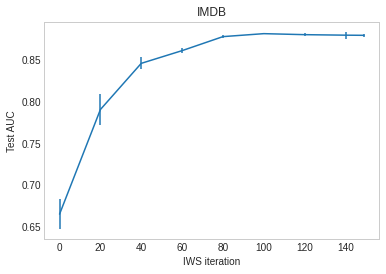

In [17]:
with plt.style.context('seaborn-whitegrid'): 
    plt.figure(figsize=(6,4))
    plt.errorbar(xs,yres.mean(0),yerr=yres.std(0),label='IWS LSE ac')
    plt.ylabel('Test AUC')
    plt.xlabel('IWS iteration')
    plt.title(dname)
    plt.grid()
    plt.show()